In [22]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import sys
import torch

import numpy as np
import pandas as pd
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
import argparse

from apex import amp
from PIL import Image
from collections import OrderedDict
from sklearn import model_selection
from tqdm import tqdm
from torch.optim import lr_scheduler
from torchvision import transforms
from PIL import Image, ImageFile
from random import randint

from data import SIIM_ACRDataset
import matplotlib.pyplot as plt

torch.cuda.empty_cache()

Mounted at /content/drive


Text(0.5, 1.0, 'Mask with Pneumothorax')

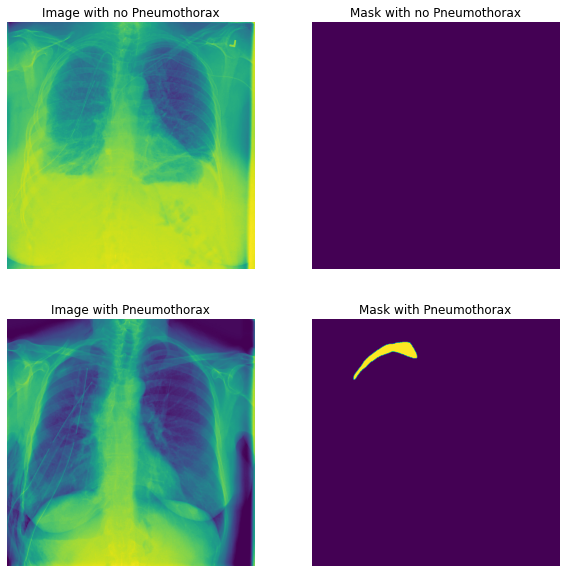

In [2]:
# without pnemotorax
img0 = Image.open("/content/drive/My Drive/Colab Notebooks/Approaching_image_classification_and_regression/input/siim-acr-pneumothorax/png_images/0_train_0_.png")
mask0 = Image.open("/content/drive/My Drive/Colab Notebooks/Approaching_image_classification_and_regression/input/siim-acr-pneumothorax/png_masks/0_train_0_.png")

# with pneumothrax
img1 = Image.open("/content/drive/My Drive/Colab Notebooks/Approaching_image_classification_and_regression/input/siim-acr-pneumothorax/png_images/2_train_1_.png")
mask1 = Image.open("/content/drive/My Drive/Colab Notebooks/Approaching_image_classification_and_regression/input/siim-acr-pneumothorax/png_masks/2_train_1_.png")

fig = plt.figure(figsize=(10,10))

plt.subplot(221)
plt.imshow(img0)
plt.axis('off')
plt.title(f"Image with no Pneumothorax")

plt.subplot(222)
plt.imshow(mask0)
plt.axis('off')
plt.title(f"Mask with no Pneumothorax")

plt.subplot(223)
plt.imshow(img1)
plt.axis('off')
plt.title(f"Image with Pneumothorax")

plt.subplot(224)
plt.imshow(mask1)
plt.axis('off')
plt.title(f"Mask with Pneumothorax")


In [3]:
parser = argparse.ArgumentParser() 

parser.add_argument(
    '--lr', default=1e-4,
    help = 'learning rate'
)
parser.add_argument(
    '--scheduler-rate', default=0.001,
    help = 'learning rate'
)
parser.add_argument(
    '--n_epochs', default=10,
    help = 'number of epochs for training the model'
)
parser.add_argument(
    '--random_state', default=42,
    help = 'random seeding'
)
parser.add_argument(
    '--encoder', default='resnet18',
    help = 'select the encoder for the model,\
        for selection of different encoders visit,\
        https://github.com/qubvel/segmentation_models.pytorch'
)
parser.add_argument(
    '--encoder_weights', default='imagenet',
    help = 'for selection of different encoder weights visit,\
        https://github.com/qubvel/segmentation_models.pytorch'
)
parser.add_argument(
    '--resize-img', default=1024,
    help = 'val for resizing the images'
)
parser.add_argument(
    '--train-batch_size', default=8,
    help='batch size for training data'
)
parser.add_argument(
    '--valid-batch_size', default=4,
    help='batch size for validation data'
)
parser.add_argument(
    '--csv-path', default="/content/drive/My Drive/Colab Notebooks/Approaching_image_classification_and_regression/input/siim-acr-pneumothorax/stage_1_test_images.csv"
)
parser.add_argument(
    '--image-path', default="/content/drive/My Drive/Colab Notebooks/Approaching_image_classification_and_regression/input/siim-acr-pneumothorax/png_images"
)
parser.add_argument(
    '--mask-path', default="/content/drive/My Drive/Colab Notebooks/Approaching_image_classification_and_regression/input/siim-acr-pneumothorax/png_masks"
)

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

parser.add_argument('--device', default=device)

args = parser.parse_args('')

In [4]:
# Define training function

def train(dataset, data_loader, model, criterion, optimizer, args):
    """
    Training loop
    -> dataset: dataset class (SIIMDataset)
    -> data_loader: torch dataset loader
    -> criterion: loss funtion
    -> optimizer: Adam
    -> args: arguments 
    """
    model.train()
    avg_loss = []

    num_batches = int(len(dataset) / data_loader.batch_size)

    # tqdm to track the progress
    tq = tqdm(data_loader, total=num_batches)
    
    for batch in tq:
        # get images and masks from the data
        inputs = batch["image"]
        targets = batch["mask"]

        inputs = inputs.to(args.device, dtype=torch.float16)
        targets = targets.to(args.device, dtype=torch.float16)

        optimizer.zero_grad()
        outputs = model(inputs)

        # calculate the loss
        loss = criterion(outputs, targets) 
        avg_loss.append(loss.item())

        # if you don't require mixed precision 
        # training use loss.backward() instead of 
        # the following lines
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()

        optimizer.step()
    
    tq.close()

    return avg_loss

In [5]:
def evaluate(dataset, data_loader, model, args):
    """
    Evaluates the model
    -> dataset: dataset class (SIIMDATASET)
    -> data_loader: torch dataset loader
    -> model: model
    -> args: arguments
    """
    # model in eval mode
    model.eval()
    valid_losses = []

    num_batches = int(len(dataset) / data_loader.batch_size)
    
    # initialize tqdm
    tq = tqdm(data_loader, total=num_batches)

    with torch.no_grad():
        for batch in tq:
            inputs = batch["image"]
            targets = batch["mask"]
            inputs = inputs.to(args.device, dtype=torch.float)
            targets = targets.to(args.device, dtype=torch.float)
            output = model(inputs)
            loss = criterion(output, targets)
            valid_losses.append(loss)
    
    # closing tqdm 
    tq.close()
    # return avg loss over all batches
    return valid_losses

In [6]:
# Read the CSV data
df = pd.read_csv(args.csv_path)

# splitting the data into training and validation
df_train, df_valid = model_selection.train_test_split(
    df, random_state=42, test_size=0.1
)

# training and validation images lists / arrays
training_images = df_train.new_filename.values
validation_images = df_valid.new_filename.values

# fetch unet model from sementation models
# with specified encoder arcitecture
model = smp.Unet(
    encoder_name = args.encoder,
    encoder_weights = args.encoder_weights,
    classes = 1,
    activation = None
)

# segmentation moel provides you with a preprocessing 
# function that can be used for normalizing images
# normalization is only applied on images and not on masks

prep_fn = smp.encoders.get_preprocessing_fn(
    args.encoder, 
    args.encoder_weights
)

# send model to device
model.to(args.device)
# init training dataset
# transform is True for training dataset
train_dataset = SIIM_ACRDataset(
    training_images,
    arguments=args,
    transform=True,
    preprocessing_fn=prep_fn,
)

# wrap training dataset in torch's dataloader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=args.train_batch_size,
    shuffle=True,
    num_workers=4
)

# initialize the validation dataset
# Disabling augmentation.
valid_dataset = SIIM_ACRDataset(
    validation_images,
    arguments=args,
    transform=False,
    preprocessing_fn=prep_fn,
)

# wrap validation dataset in torch's dataloader
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=args.valid_batch_size,
    shuffle=True,
    num_workers=4
)

# Define the criterion for loss
criterion = nn.BCEWithLogitsLoss()

# adam optimizer for faster convergence
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
#reduce learning rate when we reach a plateau on loss
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=3, verbose=True
)

# the model and optimizer is wrapped with 
# NVIDIA's apex for mixed precision training
# for trainig larger images with larger batch
# size.
model, optimizer = amp.initialize(
    model, optimizer, opt_level="O1", verbosity=0
)

# if you have more than 1 GPU use all of them
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

# some logging 
print(f"Training batch size: {args.train_batch_size}")
print(f"Validation batch size: {args.valid_batch_size}")
print(f"Epochs: {args.n_epochs}")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(valid_dataset)}")
print(f"Encoder Type: {args.encoder}")

train_losses = []
valid_losses = []
# loop over all epochs
for epoch in range(args.n_epochs):
    print(f"\nTraining Epoch: {epoch}")
    train_loss = train(
        train_dataset,
        train_loader,
        model,
        criterion,
        optimizer,
        args
    )
    print(f"\nValidation Epoch: {epoch}")
    valid_loss = evaluate(
        valid_dataset,
        valid_loader,
        model,
        args
    )
    
    train_losses.append(torch.tensor(train_loss).mean())
    valid_losses.append(torch.tensor(valid_loss).mean())

    print(f"Training Mean Loss: {torch.tensor(train_loss).mean()}")
    print(f"Validation Mean Loss: {torch.tensor(valid_loss).mean()}")
    # step the scheduler
    scheduler.step(args.scheduler_rate)
    print("\n")


  0%|          | 0/154 [00:00<?, ?it/s]

Training batch size: 8
Validation batch size: 4
Epochs: 10
Number of training images: 1234
Number of validation images: 138
Encoder Type: resnet18

Training Epoch: 0


155it [03:03,  1.18s/it]
  0%|          | 0/34 [00:00<?, ?it/s]


Validation Epoch: 0


35it [00:09,  3.72it/s]
  0%|          | 0/154 [00:00<?, ?it/s]

Training Mean Loss: 0.12569713592529297
Validation Mean Loss: 0.07251083850860596



Training Epoch: 1


155it [03:03,  1.18s/it]
  0%|          | 0/34 [00:00<?, ?it/s]


Validation Epoch: 1


35it [00:09,  3.76it/s]
  0%|          | 0/154 [00:00<?, ?it/s]

Training Mean Loss: 0.05398263782262802
Validation Mean Loss: 0.04777606576681137



Training Epoch: 2


155it [03:03,  1.18s/it]
  0%|          | 0/34 [00:00<?, ?it/s]


Validation Epoch: 2


35it [00:09,  3.79it/s]
  0%|          | 0/154 [00:00<?, ?it/s]

Training Mean Loss: 0.03655404970049858
Validation Mean Loss: 0.03687392547726631



Training Epoch: 3


155it [03:03,  1.18s/it]
  0%|          | 0/34 [00:00<?, ?it/s]


Validation Epoch: 3


35it [00:09,  3.75it/s]
  0%|          | 0/154 [00:00<?, ?it/s]

Training Mean Loss: 0.027406735345721245
Validation Mean Loss: 0.030262265354394913



Training Epoch: 4


155it [03:03,  1.18s/it]
  0%|          | 0/34 [00:00<?, ?it/s]


Validation Epoch: 4


35it [00:09,  3.66it/s]
  0%|          | 0/154 [00:00<?, ?it/s]

Training Mean Loss: 0.022212430834770203
Validation Mean Loss: 0.02610526792705059
Epoch     5: reducing learning rate of group 0 to 1.0000e-05.



Training Epoch: 5


155it [03:04,  1.19s/it]
  0%|          | 0/34 [00:00<?, ?it/s]


Validation Epoch: 5


35it [00:09,  3.65it/s]
  0%|          | 0/154 [00:00<?, ?it/s]

Training Mean Loss: 0.018087424337863922
Validation Mean Loss: 0.024459004402160645



Training Epoch: 6


155it [03:03,  1.19s/it]
  0%|          | 0/34 [00:00<?, ?it/s]


Validation Epoch: 6


35it [00:09,  3.66it/s]
  0%|          | 0/154 [00:00<?, ?it/s]

Training Mean Loss: 0.017595577985048294
Validation Mean Loss: 0.024171918630599976



Training Epoch: 7


155it [03:03,  1.18s/it]
  0%|          | 0/34 [00:00<?, ?it/s]


Validation Epoch: 7


35it [00:09,  3.74it/s]
  0%|          | 0/154 [00:00<?, ?it/s]

Training Mean Loss: 0.01708363927900791
Validation Mean Loss: 0.022825608029961586



Training Epoch: 8


155it [03:03,  1.19s/it]
  0%|          | 0/34 [00:00<?, ?it/s]


Validation Epoch: 8


35it [00:09,  3.67it/s]
  0%|          | 0/154 [00:00<?, ?it/s]

Training Mean Loss: 0.016201496124267578
Validation Mean Loss: 0.022201521322131157
Epoch     9: reducing learning rate of group 0 to 1.0000e-06.



Training Epoch: 9


155it [03:03,  1.18s/it]
  0%|          | 0/34 [00:00<?, ?it/s]


Validation Epoch: 9


35it [00:09,  3.71it/s]

Training Mean Loss: 0.015853431075811386
Validation Mean Loss: 0.022956492379307747




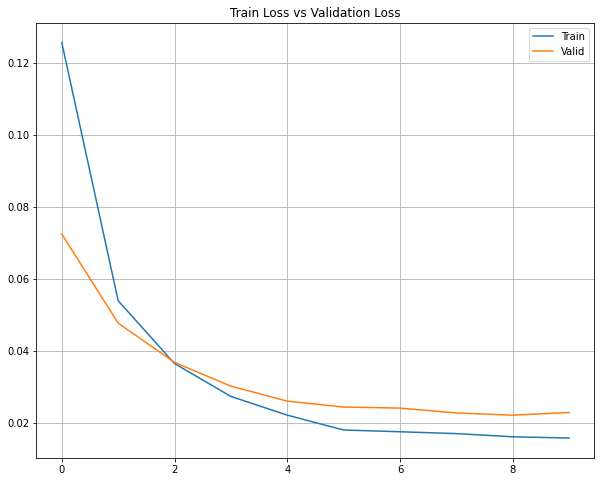

In [7]:
# Plotting Losses
fig = plt.figure(figsize=(10,8))
plt.subplot(111)
plt.plot(train_losses, label='Train')
plt.plot(valid_losses, label='Valid')
plt.title('Train Loss vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [8]:
# Save the model parameters
torch.save(model.state_dict(), './detect_pneumothorax_colab_6_ep'+str(args.n_epochs)+'.pt')

In [11]:
test_model = model = smp.Unet(
    encoder_name = args.encoder,
    encoder_weights = args.encoder_weights,
    classes = 1,
    activation = None
)

test_model = test_model.to(args.device)
test_model.load_state_dict(torch.load('./detect_pneumothorax_colab_6_ep10.pt'))
test_model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [85]:
def display_preditions(dataset, loader, model, i_x, i_y):
  """
  Shows the predictions of the UNet model
  -> dataset: Test Dataset
  -> i_x: random int for selecting a image
  -> i_y: random int for selecting a batch
  """
  data_ = dataset[0]
  x = i_x #0 to 3 # 3

  for idx, dict_ in enumerate(loader):
    if idx == i_y: #33 #12
        images = dict_["image"].to(args.device)
        masks = dict_["mask"].to(args.device)

        pred = model(images)

        input_image = images[i_x].detach().cpu().numpy()
        pred_mask = pred[i_x].detach().cpu().numpy()
        actual_mask = masks[i_x].detach().cpu().numpy()

        fig = plt.figure(figsize=(20,15))
        plt.subplot(221)
        plt.imshow(np.moveaxis(input_image, 0, -1))
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(222)
        plt.imshow(np.squeeze(actual_mask), cmap='gray')
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(223)
        plt.imshow(np.squeeze(pred_mask), cmap='gray')
        plt.title("Prediction")

        plt.axis("off")
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


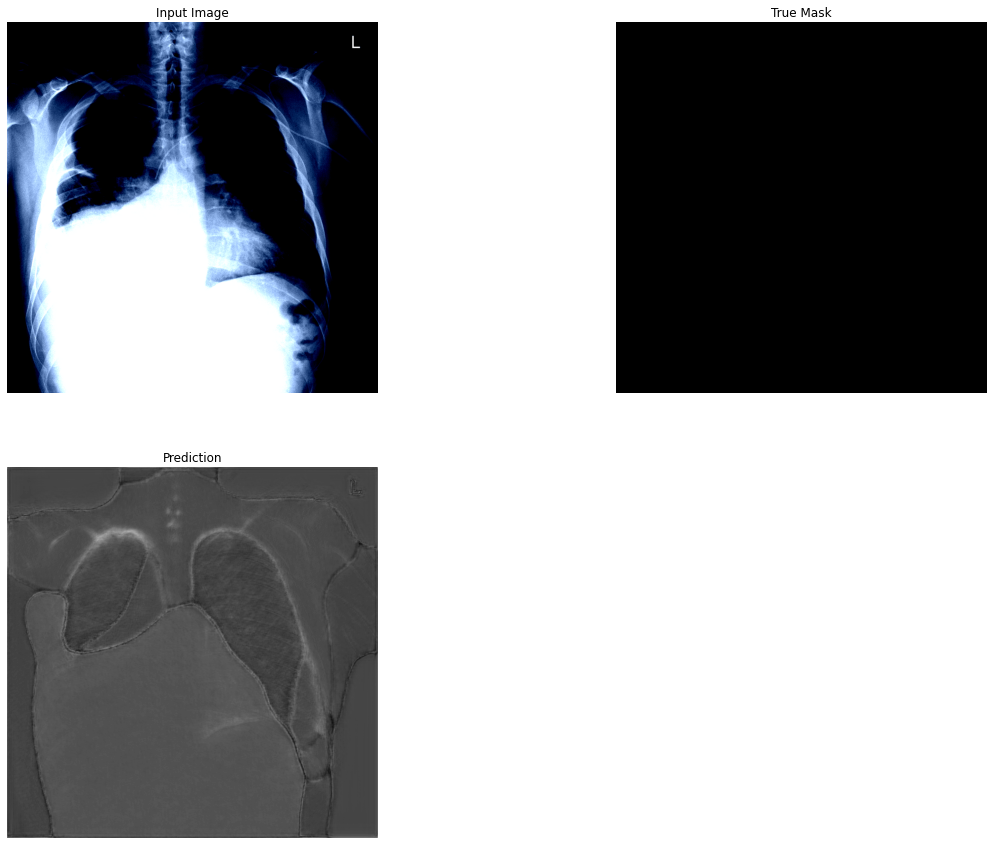

In [86]:
display_preditions(valid_dataset, valid_loader, test_model, randint(0,3), randint(0,33)) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


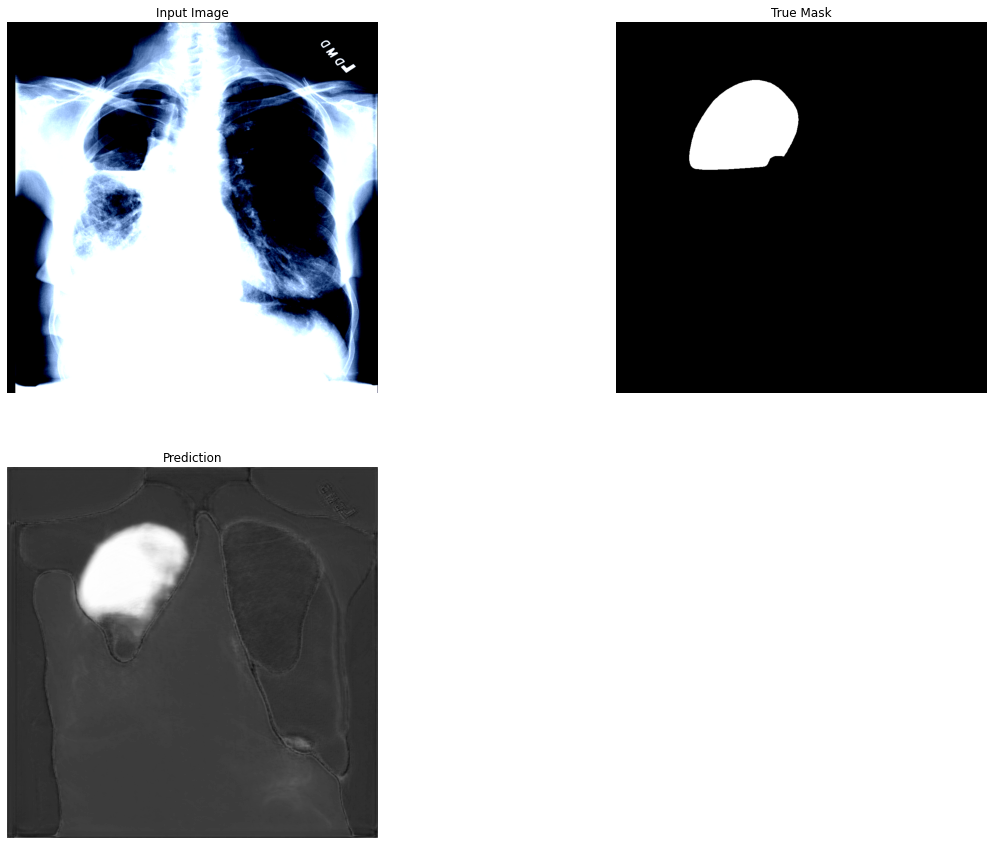

In [88]:
display_preditions(valid_dataset, valid_loader, test_model, randint(0,3), randint(0,33)) 

In [60]:
#!git clone https://github.com/NVIDIA/apex


fatal: destination path 'apex' already exists and is not an empty directory.


In [ ]:
#pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex